<h1>Installing RDKit</h1>

In [1]:
import rdkit
import deepchem as dc
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn

In [2]:
dc.__version__

'2.5.0'

In [3]:
np.__version__

'1.19.5'

In [4]:
tf.__version__

'2.6.0'

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/saharctech/Binding-Free-Energy-Prediction-Host-Guest-System/master/Results/dataset.csv')

In [6]:
df.head()

,Unnamed: 0,ID,dataset group name,Dataset Name,Host,Guest,Ex _G_(kcal/mol),Ex _G_SEM,EX _H_(kcal/mol),EX _H_SEM,...,gb_host_1-4EEL,gb_host_EELEC,gb_host_EGB,gb_host_ESURF,gb_delta_H,pb_delta_H,EX _delta_H_(kcal/mol),gb_Ex_difference,SQR_gbnsr6_Ex_difference,pb_Ex_difference
0,0,1,Mobley benchmarkset,cd-set1,acd,guest-1,-1.575,0.019,-2.17,0.05,...,423.5761,-428.9520,-96.4471,5.1691,-1.9950,-0.8408,-2.17,0.1750,0.030625,1.3292
1,1,2,Mobley benchmarkset,cd-set1,acd,guest-2,-3.533,0.004,-4.19,0.02,...,412.6663,-397.9784,-106.4154,5.0726,-11.2624,-8.4809,-4.19,-7.0724,50.018842,-4.2909
2,2,3,Mobley benchmarkset,cd-set1,acd,guest-3,-4.606,0.007,-5.46,0.03,...,426.2925,-429.3068,-95.2452,5.1352,-15.4074,-13.8234,-5.46,-9.9474,98.950767,-8.3634
3,3,4,Mobley benchmarkset,cd-set1,acd,guest-4,-2.130,0.016,-2.74,0.02,...,420.0687,-416.5215,-97.4461,5.0849,-10.5586,-11.3319,-2.74,-7.8186,61.130506,-8.5919
4,4,5,Mobley benchmarkset,cd-set1,acd,guest-5,-2.510,0.060,-2.99,0.23,...,425.7315,-435.9689,-91.2312,5.0881,-14.5517,-14.0485,-2.99,-11.5617,133.672907,-11.0585


<h1>Reading Mobley PDB files</h1>
<p>Here each PDB file will be read and saved in Mol data type defined in RDKit and used by DeepChem</p>

In [7]:
# Dictionary with complex names as keys and molecule as values
PDBs = {}
from os import listdir
from os.path import isfile, join
mypath = '.../Documents/Github/Binding-Free-Energy-Prediction-Host-Guest-System/PDB'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for f in onlyfiles:
    PDBs.update({f.split('.')[0].replace('s', '') : rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + '/' + f)})

In [8]:
# Randomly shuffling the PDBs
import random
l = list(PDBs.items())
random.shuffle(l)
PDBs = dict(l)

<h1>Featurizing</h1>
<p>GraphConv model needs ConvMolFeaturizer</p>

In [9]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
TRAIN_SET = .7

In [10]:
PDBs.pop('',None)
X = []
X_ids = []
# one_add = 0 if len(PDBs.keys()) % 2 == 0 else 1
for k in PDBs.keys():
    X_ids.append(k)
    X.append(featurizer.featurize(PDBs[k]))
split_index = int(len(X) * TRAIN_SET)
X = [x[0] for x in X]
X_train_featurized = X[:split_index]
X_test_featurized = X[split_index:]

In [11]:
host_names = [i.split('-')[0] for i in X_ids]
guest_names = ['guest-' + (i.split('-')[1].replace('s', '')) for i in X_ids]

In [12]:
host_names_train = host_names[:split_index]
guest_names_train = guest_names[:split_index]
host_names_test = host_names[split_index:]
guest_names_test = guest_names[split_index:]

In [13]:
len(host_names_train)

50

In [14]:
len(host_names_test)

22

In [15]:
x_add_train, x_add_test, y_train, y_test = [], [], [], []
for i in range(len(host_names_train)):
    new_df = df[(df['Host'] == host_names_train[i]) & (df['Guest'] == guest_names_train[i])]
    y_train.append(new_df['EX _H_(kcal/mol)'].to_numpy()[0])
    x_add_train.append(new_df[[c for c in df.columns if ('Etot' not in c) and ('delta' not in c)
                         and ('Ex_difference' not in c) and ('gb_' in c or 'VDWAALS' in c)]].to_numpy()[0])
y_train = np.array(y_train)
    
for i in range(len(host_names_test)):
    new_df = df[(df['Host'] == host_names_test[i]) & (df['Guest'] == guest_names_test[i])]
    y_test.append(new_df['EX _H_(kcal/mol)'].to_numpy()[0])
    x_add_test.append(new_df[[c for c in df.columns if ('Etot' not in c) and ('delta' not in c)
                         and ('Ex_difference' not in c) and ('gb_' in c or 'VDWAALS' in c)]].to_numpy()[0])
y_test = np.array(y_test)

In [16]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

x_preprocessed_train, x_preprocessed_test = [], []

## for X train
multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_train.append(np.array(x_add_train))

## for X test
multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_test.append(np.array(x_add_test))

In [17]:
x_train = np.full([14, np.max([v.shape[0] for v in x_preprocessed_train]),
                  np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_train):
    if len(j.shape) > 1:
        x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_train = x_train.reshape([1] + list(x_train.shape))

x_test = np.full([14, np.max([v.shape[0] for v in x_preprocessed_test]),
                  np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_test):
    if len(j.shape) > 1:
        x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_test = x_test.reshape([1] + list(x_test.shape))

<h1>Physics Guided Neural Network Model</h1>

In [18]:
# X_features = []
# for x_feat in X:
#     multiConvMol = ConvMol.agglomerate_mols([x_feat])
#     new_x_feat = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
#     for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
#         new_x_feat.append(multiConvMol.get_deg_adjacency_lists()[i])
#     X_features.append(new_x_feat)

In [19]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
batch_size = len(host_names_train)
batch_size

50

In [20]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers


class GBGraphConvModel(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
  def __init__(self, batch_size):
    super(GBGraphConvModel, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
    self.dense3 = layers.Dense(1, 
         kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
         bias_initializer=initializers.Zeros())

  def call(self, inputs):
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 15])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    return self.dense3(binding_affinity)
model = GBGraphConvModel(split_index)
model.compile(loss='mse', optimizer='adam')

2021-10-05 17:57:49.708162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.input_shapes = [i.shape for i in x_preprocessed_train]
history_train_hybrid = model.fit(x_train, y_train.reshape([1, -1]), epochs=100)

2021-10-05 17:57:49.806230: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model/graph_pool_1/Reshape_14:0", shape=(1045,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model/graph_pool_1/Reshape_13:0", shape=(1045, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model/graph_pool_1/Reshape_17:0", shape=(3372,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model/graph_pool_1/Reshape_16:0",

1/1 [==============================] - 5s 5s/step - loss: 114.9884
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 91.2430
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 84.5183
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 75.8254
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 69.7035
Epoch 6/100
1/1 [==============================] - 0s 43ms/step - loss: 66.4092
Epoch 7/100
1/1 [==============================] - 0s 44ms/step - loss: 65.9354
Epoch 8/100
1/1 [==============================] - 0s 43ms/step - loss: 62.4849
Epoch 9/100
1/1 [==============================] - 0s 46ms/step - loss: 57.2749
Epoch 10/100
1/1 [==============================] - 0s 47ms/step - loss: 52.3709
Epoch 11/100
1/1 [==============================] - 0s 46ms/step - loss: 48.4904
Epoch 12/100
1/1 [==============================] - 0s 47ms/step - loss: 46.0002
Epoch 13/100
1/1 [==============================] 

In [22]:
model.input_shapes = [i.shape for i in x_preprocessed_test]
model.modify_graphgather(len(X) - split_index)

In [23]:
model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 [==============================] - 1s 803ms/step - loss: 27.3203


27.320268630981445

In [24]:
pgnn_rmse_test = np.sqrt(44.99)
print(pgnn_rmse_test)

6.707458535093601


In [48]:
import math
train_hybrid_rmse = math.sqrt(28.89)
train_hybrid_rmse

5.374941860150675

<h1> Physics based model RMSE </h1>

In [26]:
import math
train_sum=0
for i in range(len(host_names_train)):
    new_df = df[(df['Host'] == host_names_train[i]) & (df['Guest'] == guest_names_train[i])]
    train_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2


test_sum = 0
for i in range(len(host_names_test)):
    new_df = df[(df['Host'] == host_names_test[i]) & (df['Guest'] == guest_names_test[i])]
    test_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2
    

In [27]:
physics_based_rmse_train = math.sqrt(train_sum / len(host_names_train))

In [28]:
physics_based_rmse_test = math.sqrt((test_sum) / len(host_names_test))

In [29]:
print(f"RMSE on training set is : {physics_based_rmse_train}")
print(f"RMSE on testing set is : {physics_based_rmse_test}")
# Total rmse
total_rmse_physics = np.sqrt(np.mean((df['EX _H_(kcal/mol)'].to_numpy() - df['gb_delta_H'].to_numpy())**2))
print(f"RMSE of the total data: {total_rmse_physics}")

RMSE on training set is : 9.01152001348274
RMSE on testing set is : 9.35083641254037
RMSE of the total data: 9.11654003810595


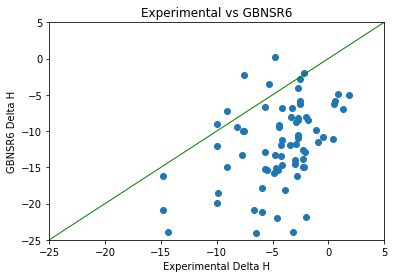

In [30]:
import matplotlib.pyplot as plt

plt.title("Experimental vs GBNSR6")
plt.scatter(x=df['EX _H_(kcal/mol)'], y=df['gb_delta_H'])
plt.xlabel("Experimental Delta H")
plt.ylabel("GBNSR6 Delta H")
plt.xlim(-25, 5)
plt.ylim(-25,5)

#reference line
plt.plot([-25, 5], [-25, 5], color='green', lw=1)

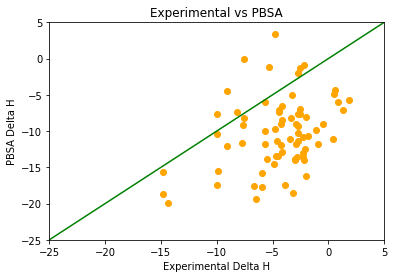

In [31]:
plt.title("Experimental vs PBSA")
plt.scatter(x=df['EX _H_(kcal/mol)'] ,y=df['pb_delta_H'], color='orange')
plt.xlabel("Experimental Delta H")
plt.ylabel("PBSA Delta H")
plt.xlim(-25, 5)
plt.ylim(-25,5)
#reference line
plt.plot([-25,5],[-25,5], color='green')

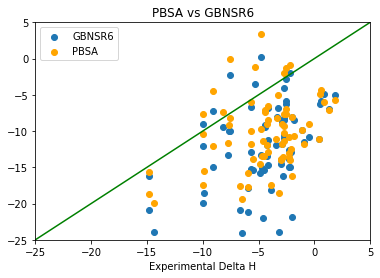

In [32]:
ax = plt.subplot()
plt.title("PBSA vs GBNSR6")
plt.xlabel('Experimental Delta H')
# plt.ylabel('gb-pb')
ax.scatter(x=df["EX _H_(kcal/mol)"], y=df['gb_delta_H'], label="GBNSR6")
ax.scatter(x=df["EX _H_(kcal/mol)"], y=df['pb_delta_H'], label="PBSA", color="orange")
plt.xlim(-25,5)
plt.ylim(-25,5)
#reference line
plt.plot([-25,5],[-25,5],color='green')
plt.legend()

In [33]:
gb_correlation_matrix = np.corrcoef(df['gb_delta_H'], df['EX _H_(kcal/mol)'])
gb_correlation_gbex = gb_correlation_matrix[0,1]
gb_r_squared = gb_correlation_gbex**2
print(gb_r_squared)

0.16443424102892062


In [34]:
pb_correlation_matrix = np.corrcoef(df['pb_delta_H'], df['EX _H_(kcal/mol)'])
pb_correlation_pbex = pb_correlation_matrix[0,1]
pb_r_squared = pb_correlation_pbex**2
print(pb_r_squared)

0.10981444457787434


<h1> Data Driven Model </h1>

In [35]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
input_shapes = [i.shape for i in x_preprocessed_train]

In [36]:
batch_size = len(host_names_train)
batch_size

50

In [37]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers

# batch_size = int(len(df) / 2)

class GBGraphConvModel(tf.keras.Model):

  def __init__(self):
    super(GBGraphConvModel, self).__init__()
    self.input_shapes = input_shapes
    self.gc1 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
#     self.dense3 = layers.Dense(1, 
#          kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
#          bias_initializer=initializers.Zeros())

  def call(self, inputs):
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [batch_size, 15])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])

    model_var = self.dense2(readout_output)
#     binding_affinity = tf.concat([model_var, x_add], axis=1)
    return model_var #self.dense3(binding_affinity)
model = GBGraphConvModel()
model.compile(loss='mse', optimizer='adam')

In [38]:
# history_dd_train = model.fit(x_train, y_train.reshape([1, -1]), epochs=200)

history_dd_train = model.fit(x_train, y_train.reshape([1, -1]), epochs=100)

Epoch 1/100


/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Reshape_14:0", shape=(1045,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Reshape_13:0", shape=(1045, 64), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Reshape_17:0", shape=(3372,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Resh

1/1 [==============================] - 4s 4s/step - loss: 39.1987
Epoch 2/100
1/1 [==============================] - 0s 65ms/step - loss: 34.6003
Epoch 3/100
1/1 [==============================] - 0s 66ms/step - loss: 29.4942
Epoch 4/100
1/1 [==============================] - 0s 64ms/step - loss: 25.8134
Epoch 5/100
1/1 [==============================] - 0s 72ms/step - loss: 23.3720
Epoch 6/100
1/1 [==============================] - 0s 68ms/step - loss: 21.6405
Epoch 7/100
1/1 [==============================] - 0s 70ms/step - loss: 19.9445
Epoch 8/100
1/1 [==============================] - 0s 67ms/step - loss: 18.8808
Epoch 9/100
1/1 [==============================] - 0s 65ms/step - loss: 18.1502
Epoch 10/100
1/1 [==============================] - 0s 66ms/step - loss: 17.4365
Epoch 11/100
1/1 [==============================] - 0s 68ms/step - loss: 16.6381
Epoch 12/100
1/1 [==============================] - 0s 78ms/step - loss: 15.9863
Epoch 13/100
1/1 [==============================] -

In [39]:
model.input_shapes = [i.shape for i in x_preprocessed_test]

In [40]:
model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 [==============================] - 1s 763ms/step - loss: 32.1225


32.12253952026367

In [41]:
dd_rmse_test = np.sqrt(46.21)
print(dd_rmse_test)

6.797793759742936


In [49]:
import math
train_dd_rmse = math.sqrt(13.56)
train_dd_rmse

3.682390527904394

Text(0, 0.5, 'Loss (Kcal/mol)')

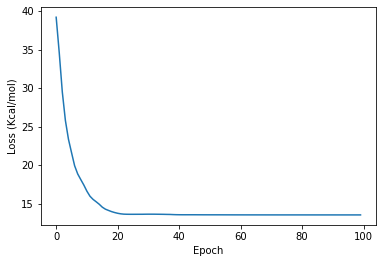

In [53]:
import matplotlib.pyplot as plt
plt.plot(history_dd_train.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")

<h1> Model Comparisons </h1>

In [50]:
# Test
from prettytable import PrettyTable
rmse_table = PrettyTable()
rmse_table.title="Test Set RMSE"
rmse_table.field_names = ["GBNSR6", "Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(physics_based_rmse_test), "{:.2f}".format(dd_rmse_test),"{:.2f}".format(pgnn_rmse_test)])
print(rmse_table)

+-----------------------------+
|        Test Set RMSE        |
+--------+-------------+------+
| GBNSR6 | Data Driven | PGNN |
+--------+-------------+------+
|  9.35  |     6.80    | 6.71 |
+--------+-------------+------+


In [51]:
# Train
rmse_table = PrettyTable()
rmse_table.title="Train Set RMSE"
rmse_table.field_names = ["GBNSR6", "Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(physics_based_rmse_train), "{:.2f}".format(train_dd_rmse),"{:.2f}".format(train_hybrid_rmse)])
print(rmse_table)

+-----------------------------+
|        Train Set RMSE       |
+--------+-------------+------+
| GBNSR6 | Data Driven | PGNN |
+--------+-------------+------+
|  9.01  |     3.68    | 5.37 |
+--------+-------------+------+


<h1> Loss per epoch </h1>

In [46]:
print(model.summary())

Model: "gb_graph_conv_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_conv_2 (GraphConv)     multiple                  102144    
_________________________________________________________________
batch_normalization_3 (Batch multiple                  256       
_________________________________________________________________
graph_pool_2 (GraphPool)     multiple                  0         
_________________________________________________________________
graph_conv_3 (GraphConv)     multiple                  87360     
_________________________________________________________________
batch_normalization_4 (Batch multiple                  0 (unused)
_________________________________________________________________
graph_pool_3 (GraphPool)     multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple        

Text(0, 0.5, 'Loss (Kcal/mol)')

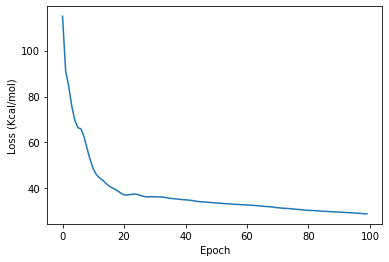

In [52]:
import matplotlib.pyplot as plt
plt.plot(history_train_hybrid.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")